### Labrador Embeddings

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

from src.preprocessing import preprocess_df, TextEncoder, set_labels_features
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer
from src.dataset import LabradorDataset

from src.train import train_labrador
from src.test import test_model

### Constants

In [2]:
# Dataset:
FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

# Device:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

# Data loader: 
test_size = 0.2
batch_size = 512
num_workers = 4
max_len = 8
MASKING = 0.40

# Model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 4 #12
num_blocks = 10 #12
transformer_feedforward_dim = 1024 #3072
dropout_rate = 0.3
continuous_head_activation = 'relu'

# Training:
optimizer = 'Adam'
num_epochs = 12
save_model = True
model_path = 'labrador_model.pth'
categorical_loss_weight = 1.0
continuous_loss_weight = 1.0
lr = 8e-6


### Read dataset

In [3]:
df = pd.read_csv(FILE)
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [4]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS)

### Generate Sequences

In [5]:
# Generate the sequences:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [6]:
mrl.head(3)

itemid,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,Wbc,nstr,lab_ids,lab_values
0,10000032,22595853.0,2180-05-07,0.530612,0.007895,0.258621,0.609524,0.088028,0.585253,0.027731,0.004782,Bic 0.5306122448979591 Crt 0.00789473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.5306122448979591, 0.007894736842105262, 0.2..."
1,10000032,22841357.0,2180-06-27,0.469388,0.007895,0.318966,0.504762,0.102113,0.571429,0.055462,0.007515,Bic 0.46938775510204084 Crt 0.0078947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.007894736842105262, 0...."
2,10000032,25742920.0,2180-08-06,0.489796,0.015789,0.413793,0.504762,0.130282,0.557604,0.053782,0.008539,Bic 0.48979591836734687 Crt 0.0157894736842105...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.48979591836734687, 0.015789473684210523, 0...."


In [7]:
# See the largest element in: 
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019.0,[Bic 0.4489795918367347 Crt 0.0289473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.02894736842105263, 0.17..."
1,20000024.0,[Bic 0.46938775510204084 Crt 0.028947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.02894736842105263, 0.3..."
2,20000034.0,[Bic 0.4489795918367347 Crt 0.0605263157894736...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.06052631578947368, 0.28..."


#### Train and Test Split

In [8]:
lab_ids = grouped_mrl.lab_ids.values
lab_values = grouped_mrl.lab_values.values

lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(lab_ids, lab_values, test_size=test_size, random_state=42)

#### Tokenize

In [9]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)

In [10]:
# Example of how to use the tokenizer:
tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=10)

{'input_ids': array([[ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10],
        [ 7,  0,  6,  5,  4,  2,  3,  1, 10, 10]]),
 'continuous': array([[6.73469388e-01, 7.89473684e-02, 1.46551724e-01, 6.09523810e-01,
         3.80281690e-01, 6.31336406e-01, 4.15966387e-02, 6.94523511e-03,
         1.00000000e+01, 1.00000000e+01],
        [6.12244898e-01, 2.89473684e-02, 1.37931034e-01, 7.04761905e-01,
         9.85915493e-02, 3.50230415e-01, 7.85714286e-02, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [5.30612245e-01, 2.10526316e-02, 2.06896552e-01, 6.28571429e-01,
         5.63380282e-02, 4.42396313e-01, 1.18067227e-01, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [4.48979592e-01, 1.84210526e-02, 2.32758621e-01, 6.28571429e-01,
         3.16901408e-02, 6.77419355e-01, 1.07983193e-01, 1.04747808e-02,
         1.

### Dataloader

In [11]:
dataset_train = LabradorDataset(continuous=lab_values_train, categorical=lab_ids_train, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)

# Dataloader:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Wbc': 1, 'Hgb': 2, 'Plt': 3, 'Ure': 4, 'Sod': 5, 'Pot': 6, 'Bic': 7}
{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Wbc': 1, 'Hgb': 2, 'Plt': 3, 'Ure': 4, 'Sod': 5, 'Pot': 6, 'Bic': 7}


### Model

In [12]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

In [13]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation=continuous_head_activation, dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-9): 10 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dr

### Train the model

In [14]:
# Loss functions
categorical_loss_fn = nn.CrossEntropyLoss()
continuous_loss_fn = nn.MSELoss()

100%|██████████| 104/104 [00:06<00:00, 16.97it/s]


Epoch 1/12, Training Loss: 2.2413588736368264, Validation Loss: 1.9858163801523356


100%|██████████| 104/104 [00:06<00:00, 16.87it/s]


Epoch 2/12, Training Loss: 1.9672557993787498, Validation Loss: 1.9439135159437473


100%|██████████| 104/104 [00:06<00:00, 16.87it/s]


Epoch 3/12, Training Loss: 1.940094983232194, Validation Loss: 1.926604790183214


100%|██████████| 104/104 [00:06<00:00, 17.02it/s]


Epoch 4/12, Training Loss: 1.932235980667354, Validation Loss: 1.934294195129321


100%|██████████| 104/104 [00:06<00:00, 16.88it/s]


Epoch 5/12, Training Loss: 1.9290834495410827, Validation Loss: 1.9242398887872696


100%|██████████| 104/104 [00:06<00:00, 17.02it/s]


Epoch 6/12, Training Loss: 1.9249660637643602, Validation Loss: 1.919661739697823


100%|██████████| 104/104 [00:06<00:00, 16.86it/s]


Epoch 7/12, Training Loss: 1.9218617395502358, Validation Loss: 1.9246218777619875


100%|██████████| 104/104 [00:06<00:00, 16.92it/s]


Epoch 8/12, Training Loss: 1.9230684327042622, Validation Loss: 1.9177280091322386


100%|██████████| 104/104 [00:06<00:00, 16.98it/s]


Epoch 9/12, Training Loss: 1.920074728951938, Validation Loss: 1.915937262085768


100%|██████████| 104/104 [00:06<00:00, 16.81it/s]


Epoch 10/12, Training Loss: 1.920303461632291, Validation Loss: 1.9146514534950256


100%|██████████| 104/104 [00:06<00:00, 16.94it/s]


Epoch 11/12, Training Loss: 1.91868687885395, Validation Loss: 1.9168558487525353


100%|██████████| 104/104 [00:06<00:00, 16.85it/s]


Epoch 12/12, Training Loss: 1.9190885214413997, Validation Loss: 1.9156311119978244


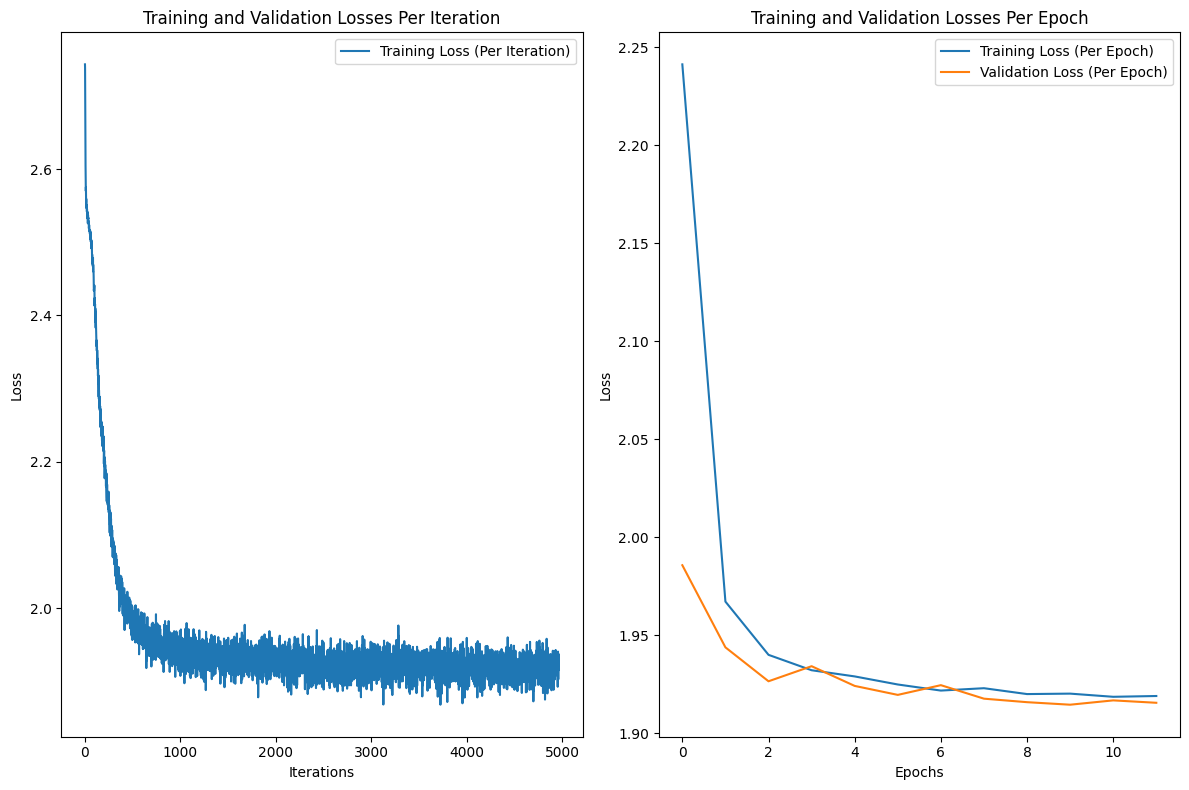

In [15]:
# Train and validate the model
trained_model = train_labrador(model, train_loader, test_loader, categorical_loss_fn, continuous_loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=device, save_model=save_model, model_path=model_path, categorical_loss_weight=categorical_loss_weight, continuous_loss_weight=continuous_loss_weight, lr=lr)

### Test the model

In [16]:
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=0)
# Dataloader:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Crt': 0, 'Wbc': 1, 'Hgb': 2, 'Plt': 3, 'Ure': 4, 'Sod': 5, 'Pot': 6, 'Bic': 7}


In [17]:
test_model(model, test_loader, device, COLUMNS)

Evaluating Bic: 


  3%|▎         | 3/104 [00:00<00:13,  7.29it/s]

Preds: [0.514218807220459, 0.5179949998855591, 0.5160105228424072, 0.5181593298912048, 0.5173887014389038, 0.5178527235984802, 0.5167436599731445, 0.5116348266601562, 0.508784830570221, 0.5150989890098572, 0.5155614614486694, 0.5153014659881592, 0.5182420015335083, 0.5134782791137695, 0.5103710889816284, 0.5132918953895569, 0.5167942047119141, 0.5183770060539246, 0.5152066349983215, 0.5121230483055115, 0.5173952579498291, 0.4996969997882843, 0.5160592794418335, 0.5188381671905518, 0.5196415781974792, 0.516944408416748, 0.5199286341667175, 0.5162349343299866, 0.5157026648521423, 0.5191012024879456, 0.5164786577224731, 0.516703724861145, 0.5174960494041443, 0.5181660652160645, 0.5175169110298157, 0.5177950263023376, 0.5159177780151367, 0.5152301788330078, 0.5163831114768982, 0.5182037353515625, 0.5157322883605957, 0.5132775902748108, 0.5176511406898499, 0.5180697441101074, 0.5157209634780884, 0.5178502798080444, 0.5168100595474243, 0.5147024393081665, 0.5152279734611511, 0.51803928613662

100%|██████████| 104/104 [00:06<00:00, 17.17it/s]


RMSE: 0.086
MAE: 0.066
R2: -0.201
-------------------
Evaluating Crt: 


  3%|▎         | 3/104 [00:00<00:13,  7.60it/s]

Preds: [0.013148903846740723, 0.01090119406580925, 0.006791617721319199, 0.01159275695681572, 0.010974090546369553, 0.015916194766759872, 0.006202574819326401, 0.025634631514549255, 0.03304709494113922, 0.009231094270944595, 0.017807286232709885, 0.019408423453569412, 0.011355645954608917, 0.014471672475337982, 0.02920610085129738, 0.015622679144144058, 0.005462683737277985, 0.009227879345417023, 0.012772046029567719, 0.026670828461647034, 0.010867584496736526, 0.03640979528427124, 0.01039702445268631, 0.009267233312129974, 0.007637381553649902, 0.011527691036462784, 0.007327713072299957, 0.010798238217830658, 0.014423288404941559, 0.013001296669244766, 0.014952465891838074, 0.014017883688211441, 0.0076491497457027435, 0.010392781347036362, 0.012452103197574615, 0.00868922472000122, 0.0037129782140254974, 0.009986989200115204, 0.012776628136634827, 0.006614513695240021, 0.01261233165860176, 0.021282579749822617, 0.005481112748384476, 0.011632867157459259, 0.020216207951307297, 0.007860

100%|██████████| 104/104 [00:06<00:00, 17.21it/s]


RMSE: 0.042
MAE: 0.021
R2: -0.088
-------------------
Evaluating Pot: 


  3%|▎         | 3/104 [00:00<00:13,  7.42it/s]

Preds: [0.21456271409988403, 0.21408790349960327, 0.21286725997924805, 0.2132188081741333, 0.21426796913146973, 0.2161296308040619, 0.21277126669883728, 0.2217084765434265, 0.22570180892944336, 0.21218883991241455, 0.21697306632995605, 0.21804973483085632, 0.2131069004535675, 0.21529045701026917, 0.22286683320999146, 0.21650955080986023, 0.21368125081062317, 0.21349051594734192, 0.21396872401237488, 0.22247973084449768, 0.2149316966533661, 0.23958683013916016, 0.2133975625038147, 0.21363845467567444, 0.2115379273891449, 0.2145470380783081, 0.212471604347229, 0.21375176310539246, 0.216776043176651, 0.21363556385040283, 0.2154100239276886, 0.2155889868736267, 0.21291261911392212, 0.2133103311061859, 0.21447083353996277, 0.212672621011734, 0.2099393904209137, 0.21268734335899353, 0.21524083614349365, 0.21201786398887634, 0.21445763111114502, 0.21822309494018555, 0.21327653527259827, 0.21614563465118408, 0.21744230389595032, 0.21512922644615173, 0.21316659450531006, 0.2182224690914154, 0.2

100%|██████████| 104/104 [00:06<00:00, 17.10it/s]


RMSE: 0.046
MAE: 0.034
R2: 0.012
-------------------
Evaluating Sod: 


  3%|▎         | 3/104 [00:00<00:13,  7.47it/s]

Preds: [0.6789502501487732, 0.6838781833648682, 0.6801260709762573, 0.6839471459388733, 0.6825305819511414, 0.6846257448196411, 0.6810609698295593, 0.6801914572715759, 0.6752591133117676, 0.6795095801353455, 0.6825444102287292, 0.6816083192825317, 0.6833917498588562, 0.6784079074859619, 0.678094208240509, 0.6793853640556335, 0.681510865688324, 0.6842001080513, 0.6786830425262451, 0.6800274848937988, 0.683073878288269, 0.6635575890541077, 0.6803810596466064, 0.6848034262657166, 0.6849880814552307, 0.6819610595703125, 0.6853744983673096, 0.6798425316810608, 0.6817539930343628, 0.6848989129066467, 0.6825931668281555, 0.6833723783493042, 0.6816713213920593, 0.6834397912025452, 0.6831538081169128, 0.6832171678543091, 0.6788750290870667, 0.678572952747345, 0.6833250522613525, 0.6816816329956055, 0.6809367537498474, 0.6801888346672058, 0.6823772192001343, 0.6853371858596802, 0.6821327805519104, 0.6833857297897339, 0.681358814239502, 0.6818106770515442, 0.6783285737037659, 0.6825389862060547, 

100%|██████████| 104/104 [00:06<00:00, 17.29it/s]


RMSE: 0.066
MAE: 0.057
R2: -2.087
-------------------
Evaluating Ure: 


  3%|▎         | 3/104 [00:00<00:13,  7.49it/s]

Preds: [0.051079921424388885, 0.04741929471492767, 0.04890923947095871, 0.0467255637049675, 0.04910925775766373, 0.04786243289709091, 0.05023425072431564, 0.050834961235523224, 0.06100023537874222, 0.04905715584754944, 0.048166461288928986, 0.05241081863641739, 0.04775518178939819, 0.051692284643650055, 0.054055482149124146, 0.05132824927568436, 0.04829385131597519, 0.047284260392189026, 0.05149918049573898, 0.052723608911037445, 0.048072449862957, 0.08260145038366318, 0.05006196349859238, 0.046901099383831024, 0.04688233882188797, 0.04964231699705124, 0.04650125652551651, 0.05072077363729477, 0.04898660629987717, 0.04706520587205887, 0.04890819638967514, 0.04833260923624039, 0.04851795732975006, 0.04837366193532944, 0.047796621918678284, 0.047012366354465485, 0.04717463254928589, 0.05032602697610855, 0.04724935442209244, 0.05039789527654648, 0.04970937222242355, 0.05155632644891739, 0.047620199620723724, 0.04666099697351456, 0.05100470036268234, 0.04811563342809677, 0.0485912039875984

100%|██████████| 104/104 [00:06<00:00, 17.25it/s]


RMSE: 0.064
MAE: 0.036
R2: -0.065
-------------------
Evaluating Hgb: 


  3%|▎         | 3/104 [00:00<00:13,  7.56it/s]

Preds: [0.5399364233016968, 0.541183352470398, 0.5419739484786987, 0.5408449769020081, 0.5413939952850342, 0.5397924184799194, 0.5416229963302612, 0.5346595048904419, 0.5319713354110718, 0.5413134694099426, 0.5398311614990234, 0.5386902093887329, 0.5406619310379028, 0.5398018956184387, 0.5359969735145569, 0.5391350388526917, 0.542313814163208, 0.5407422780990601, 0.5404272675514221, 0.536940336227417, 0.5408254265785217, 0.5276629328727722, 0.5414469838142395, 0.5411760807037354, 0.5418480634689331, 0.5404456853866577, 0.5416707396507263, 0.5405784845352173, 0.5405182838439941, 0.5408574342727661, 0.5405387282371521, 0.5406643748283386, 0.5410305261611938, 0.5412242412567139, 0.5409179329872131, 0.5413733720779419, 0.5419121384620667, 0.5408492088317871, 0.5414263606071472, 0.5410057306289673, 0.5394576191902161, 0.5386747717857361, 0.5424100756645203, 0.540621817111969, 0.53822922706604, 0.5413573980331421, 0.54034024477005, 0.5379800796508789, 0.5400477051734924, 0.541907012462616, 0

100%|██████████| 104/104 [00:06<00:00, 17.26it/s]


RMSE: 0.099
MAE: 0.081
R2: -0.107
-------------------
Evaluating Plt: 


  3%|▎         | 3/104 [00:00<00:13,  7.59it/s]

Preds: [0.07656728476285934, 0.07356037944555283, 0.07380513846874237, 0.07423011213541031, 0.07549888640642166, 0.07456523925065994, 0.07480277866125107, 0.07595589756965637, 0.08248645067214966, 0.07510782033205032, 0.07452275604009628, 0.07733289152383804, 0.07470876723527908, 0.07689516991376877, 0.07912228256464005, 0.07638152688741684, 0.07278763502836227, 0.07332570850849152, 0.07671809941530228, 0.07704789191484451, 0.07348769903182983, 0.09252335876226425, 0.07558518648147583, 0.07306895405054092, 0.07393340021371841, 0.07508773356676102, 0.07267072051763535, 0.07576113194227219, 0.07490964978933334, 0.07473613321781158, 0.07515522092580795, 0.07458553463220596, 0.0738842710852623, 0.0746551901102066, 0.07444564253091812, 0.07347013056278229, 0.07287424057722092, 0.07579133659601212, 0.07343301922082901, 0.07567654550075531, 0.07535646110773087, 0.077044777572155, 0.072422556579113, 0.07173051685094833, 0.07711641490459442, 0.07286008447408676, 0.07397980988025665, 0.075947396

100%|██████████| 104/104 [00:06<00:00, 17.25it/s]


RMSE: 0.050
MAE: 0.034
R2: -0.147
-------------------
Evaluating Wbc: 


  3%|▎         | 3/104 [00:00<00:13,  7.73it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

100%|██████████| 104/104 [00:06<00:00, 17.30it/s]

RMSE: 0.012
MAE: 0.010
R2: -1.680
-------------------


{'Bic': {'rmse': [0.086016738195594],
  'mae': [0.06613384850597469],
  'r2': [-0.20131242006529027]},
 'Crt': {'rmse': [0.042110525297904704],
  'mae': [0.020773371241305585],
  'r2': [-0.08753747856980088]},
 'Pot': {'rmse': [0.04585034396300611],
  'mae': [0.034253659384675235],
  'r2': [0.012102459024660561]},
 'Sod': {'rmse': [0.06622855158581785],
  'mae': [0.05665971828306621],
  'r2': [-2.086504283292569]},
 'Ure': {'rmse': [0.0637500391866958],
  'mae': [0.03618826496614874],
  'r2': [-0.06523546560134696]},
 'Hgb': {'rmse': [0.09948469824450878],
  'mae': [0.08100428777511412],
  'r2': [-0.10704083890135707]},
 'Plt': {'rmse': [0.049975810210515205],
  'mae': [0.03447125158892357],
  'r2': [-0.1474695135895432]},
 'Wbc': {'rmse': [0.012445089987730659],
  'mae': [0.00985360168744061],
  'r2': [-1.6802015094659697]}}